In [12]:
!pip install pycm livelossplot torchvision
%pylab inline
from sklearn.metrics import accuracy_score

from livelossplot import PlotLosses
from pycm import *
from PIL import Image
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.models as models
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score
import csv
import io

class CustomDataset(Dataset):
    def __init__(self, dataset, indices, transform=None):
        """
        Class to create a CustomDataset that will allow for VGG-11 to be trained on
        the entire dataset without hitting the maximum RAM. 
        
        Args:
            dataset: ImageFolder containing the whole set of data to be subsampled
            indices: Indices, which will be taken from stratified shuffle split
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.samples = []
        for index in indices:
            self.samples.append((dataset.samples[index][0]))
        
        self.targets = np.asarray(dataset.targets)[indices]
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample, label = Image.open(self.samples[idx]).convert('RGB'), self.targets[idx]
        if self.transform:
            sample = self.transform(sample)
    
        sample = sample.float()
        
        return sample, label

def set_seed(seed):
    """
    This function is used to set all the random seeds to a fixed value and take out any randomness from cuda kernels.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Populating the interactive namespace from numpy and matplotlib
Cuda installed! Running on GPU!


/opt/conda/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['seed', 'indices']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [13]:
# set path to folder containing the training images and labels
path = '../input/train'

# create imagefolder containing full training set
full_data = ImageFolder(path, transform=transforms.ToTensor())

# create teorch tensor of length 100,000 (length of full data set)
data = torch.zeros(100000)

# stratified split of full training data set  (90:10 training and validation data set)
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(data, full_data.targets)
# output the indices from the full training set for the new training new and validation set respectively
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

# set to none to remove from memory
shuffler = None
data = None 

In [14]:
# hyperparameters chosen that outputs the best f_score
seed = 42
lr = 1e-3
momentum = 0.5
batch_size = 20
test_batch_size = 64
n_epochs = 6
weight_decay = 1e-3

# means and stds of the full training data set (pre-calculated) in each channel (total of 3 channels as RGB)
# this is used to perform Z-normalization on the full training set
means = [0.4802486,0.44807222,0.39754647]
stds = [0.2769856,0.26906505,0.2820814]

# list of transforms to perform on the training set - the order matters
# 1. Randomly rotate PIL images up to 10 degrees
# 2. Randomly (probability=0.5) do left-right flip on PIL image
# 3. convert the PIL images into torch tensors using .ToTensor()
# 4. normalize every pixel per channel using .Normalize()
# these transforms will also be used when training model on the entire training set
train_normalise_aug = transforms.Compose([transforms.RandomRotation(10), transforms.RandomHorizontalFlip(p=0.5), transforms.ToTensor(), transforms.Normalize(mean=np.array(means), std=np.array(stds))])

# transforms for validation and, later on, test set - convert to tensor and normalize
train_normalise = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=np.array(means), std=np.array(stds))])

# load training and test images with CustomDataset and apply defined transforms
train_data = CustomDataset(full_data, indices[0], transform=train_normalise_aug)
val_data = CustomDataset(full_data, indices[1], transform=train_normalise)

In [15]:
#code below is for transfer learning (finetuning or feature extraction)
#here we only finetune
#VGG-11 bn used from "Very Deep Convolutional Networks For Large-Scale Image Recognition"
# <https://arxiv.org/pdf/1409.1556.pdf>

def initialize_model(num_classes, use_pretrained=False):
    """
    Function to initialise VGG-11 but some changes and additions to the last layer. Here we chose to do finetuning, 
    instead of feature extraction, as it improved accuracy. Even though we did not resize the images to 224 
    (resizing caused memory to overflow), we found that using the pretrained model improved accuracy. 
    
    Args:
        num_classes: Set to 200 globally.
        Use_pretrainen: A bool. Default is False. 
        
    """
    model_ft = models.vgg11_bn(pretrained=use_pretrained) 
    #num_fts: number of input features going into the last layer
    num_ftrs = model_ft.classifier[6].in_features 
    #changing last layer and adding extra layer using PReLu activation function (rest of VGG-11 uses ReLU)
    model_ft.classifier[6] = nn.Sequential(nn.Linear(num_ftrs,int(num_ftrs/4)), nn.PReLU(), nn.Linear(int(num_ftrs/4),num_classes)) #output layer must be changed so it outputs 200 classes, but the input features (num_ftrs) stays the same
    input_size = 64

    return model_ft, input_size

num_classes = 200 #set the number of classes

model_ft, input_size = initialize_model(num_classes, use_pretrained=False)

#print the model that was just instantiated to see all the layers 
print(model_ft)

#send the model to GPU
model_ft = model_ft.to(device)

#the parameters to be optimized
params_to_update = model_ft.parameters()

#initialize optimizer - SGD, as used in Simonyan and Zisserman (2015)
optimizer_ft = optim.SGD(params_to_update, lr=lr, momentum=momentum)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [16]:
def train(model, optimizer, criterion, data_loader):
    """
    Function to train a model on a training dataset.
    
    Args:
        model: The model to be trained.
        optimizer: Iterative method to reduce the loss function.
        criterion: The way in which the loss function is calculated.
        data_loader: Subsamples over the training dataset. 
    
    """
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X)
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()  
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
    """
    Function that calculates the accuracy and log loss using a validation dataset.
    
    Args:
        model: A trained model. 
        criterion: The way in which the loss function is calculated.
        data_loader: Subsamples over the validation dataset. 
    
    """
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X) 
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)

def evaluate(model, data_loader):
    """
    Function to create a prediction based on test images using a trained model.
    If test images have true labels, output will be two arrays containing predicted 
    and true labels respectively.
    If test images do not have true labels, output will be two arrays of predicted and 
    zeros respectively.
    
    Args:
        model: The trained model.
        data_loader: Subsamples over the test dataset. 
    
    """
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
            
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

def f1_evaluate(model, data_loader):
    """
    Function to output the f_score based on predicted and true labels of a test dataset.
    
    Args: 
        model: The trained model.
        data_loader: Subsamples over the test dataset. 
        
    """
    y_pred, y_true = evaluate(model, data_loader)
    score = f1_score(y_true, y_pred, average='macro')
    return score

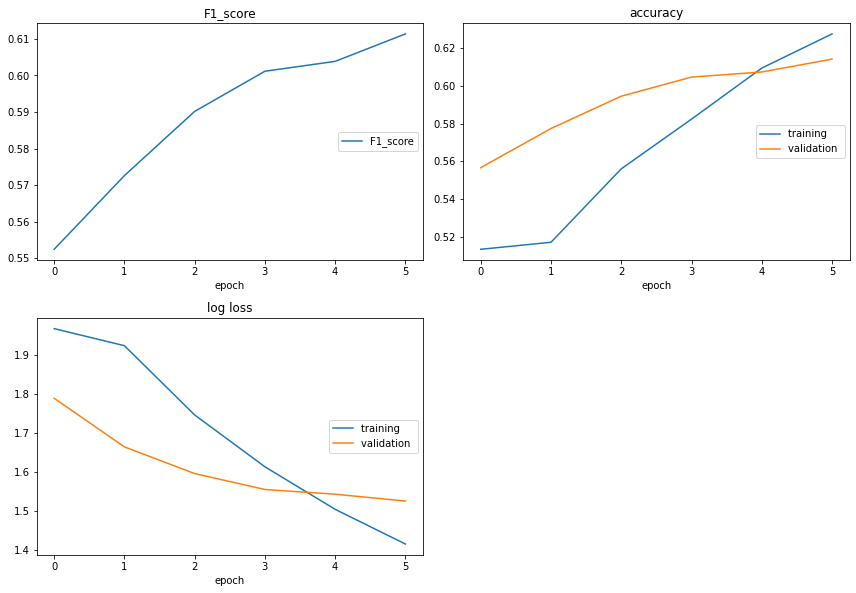

F1_score
	F1_score         	 (min:    0.502, max:    0.611, cur:    0.611)
accuracy
	training         	 (min:    0.513, max:    0.627, cur:    0.627)
	validation       	 (min:    0.557, max:    0.614, cur:    0.614)
log loss
	training         	 (min:    1.416, max:    1.969, cur:    1.416)
	validation       	 (min:    1.526, max:    1.790, cur:    1.526)


In [18]:
#setting the seed so non-random result occurs
set_seed(seed)

#initialize the loss function
criterion = nn.CrossEntropyLoss()

def train_model():
  """
  Function that outputs plots of log loss, accuracy, and f-score using training and validation datasets 
  during training. Output is over desired number of epochs (global variable n_epochs) and using the 
  globally set hyperparameters.
    
  """
  set_seed(seed)
  pre_optimizer = torch.optim.SGD(model_ft.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
  criterion = nn.CrossEntropyLoss() 
  
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
  validation_loader = DataLoader(val_data, batch_size=test_batch_size, shuffle=False, num_workers=0)
  
  liveloss = PlotLosses()
  for epoch in range(n_epochs):
      logs = {}
      train_loss, train_accuracy = train(model_ft, optimizer_ft, criterion, train_loader)

      logs['' + 'log loss'] = train_loss.item()
      logs['' + 'accuracy'] = train_accuracy.item()

      validation_loss, validation_accuracy = validate(model_ft, criterion, validation_loader)
      logs['val_' + 'log loss'] = validation_loss.item()
      logs['val_' + 'accuracy'] = validation_accuracy.item()
    
      f1score_accuracy = f1_evaluate(model_ft, validation_loader)
      logs['F1_score'] = f1score_accuracy.item()
      
      liveloss.update(logs)
      liveloss.draw()
      
  return model_ft

#train the model and output log loss, accuracy, and f-score over 6 epochs
model = train_model()

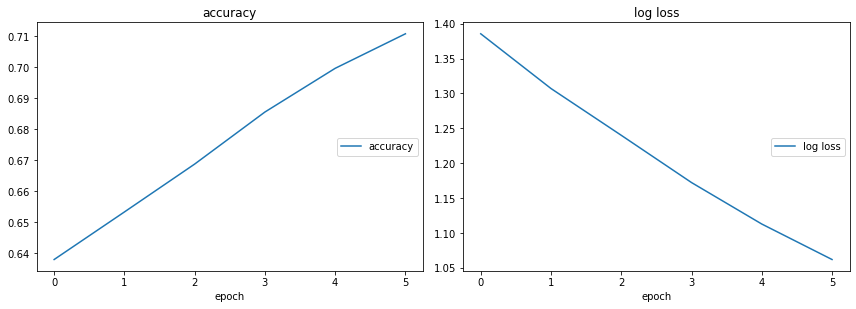

accuracy
	accuracy         	 (min:    0.247, max:    0.711, cur:    0.711)
log loss
	log loss         	 (min:    1.062, max:    3.574, cur:    1.062)


In [19]:
#reset training dataloader for the full training set
full_data = ImageFolder(path, transform=train_normalise_aug)
train_loader = DataLoader(full_data, batch_size=batch_size, shuffle=True, num_workers=0)

#main training loop function for full training set
def full_train():
    """
    Function to train model on the whole training dataset.
    
    """
    
    liveloss = PlotLosses()
    for epoch in range(n_epochs):
        logs = {}
        train_loss, train_accuracy = train(model, optimizer_ft, criterion, train_loader)

        logs['' + 'log loss'] = train_loss.item()
        logs['' + 'accuracy'] = train_accuracy.item()

        liveloss.update(logs)
        liveloss.draw()
        
    return model

model = full_train()

In [ ]:
# load test images and input into ImageFolder, and then DataLoader
path = '../input/test'
test_data = ImageFolder(path, transform=train_normalise)
test_loader = DataLoader(test_data, batch_size=test_batch_size, shuffle=False, num_workers=0)

# get predicted class using trained model
y_pred, y_true = evaluate(model, test_loader)

In [21]:
class CustomImageFolder(ImageFolder):
    """
    Custom ImageFolder class to store individual path and name of test image files in tuple. 
    Used only on the test data set to create the .csv file containing the name of test image files and their predicted labels. 
    
        Args: ImageFolder: A dataloader from the pytorch library to load images.
    """
    def __getitem__(self, index):
        
        # this is what ImageFolder normally returns 
        original_tuple = super(CustomImageFolder, self).__getitem__(index)
        path = self.imgs[index][0]
        new_tuple = (original_tuple + (path,))
        return new_tuple

In [22]:
# function to write results of predicted class into csv format
# path_to_test should be defined by user to direct to where the test images folder is
# exmaple: path_to_test = './data/test/images/'
# note: the "/" at the end of path is required
path_to_test = './input/test/images/'
path_len = len(path_to_test)

# load test images with CustomImageFolder, so it can later be used to create a csv file, and apply train_normalise
test_data_raw = CustomImageFolder(path, transform=train_normalise)

def write_csv(csv_name):
    """
    Function to output filename and predicted label of test images into csv format.
    First column is the filename, second column is the label in integer of the 200 classes.
    Headers are included as "Filename" and "Label".
    
    Args:
        csv_name: desired name of the output csv file. 
    """
    with open(csv_name, 'w', newline='') as newFile:
        
        writer = csv.writer(newFile, lineterminator='\n')
        writer.writerow(("Filename","Label"))
        i = 0 
        for y in y_pred:
            writer.writerow((test_data_raw[i][2][path_len:-4] + 'jpeg', y.astype("U")))
            i += 1        

    return 0

In [ ]:
# defining the name of desired csv file then call function
csv_name = 'full.csv'
write_csv(csv_name)